$$\textbf{Section 4: Ising Model}$$

2) Perform a series of runs with $\alpha \in$ [0, 1] and plot the average energy of the system and its magnetisation as a function of $\alpha$ . Estimate the critical value of  αα at which the phase transition occurs. Is it compatible with Onsager's exact solution for the system?

In [1]:
from matplotlib import pyplot as plt
import numpy as np
%matplotlib inline
from matplotlib import rcParams
from matplotlib import animation
from IPython.display import HTML
import matplotlib.cm as cm 
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 16

On a besoin de la fonction *ising_model_metropolis*, *energy_at_site* et *metropolis_at_site* définies dans le MOOC. Notons que pour les deux premières fonctions, nous avons ajouté nx et ny en arguments, par convenance pour la suite.

In [2]:
def energy_at_site(sp,alpha,sigma,ix,iy,nx,ny):
    """ Computes the contribution to the energy for a given spin
    at location ix,iy for a lattice with periodic boundary conditions
   
    Parameters:
    ----------
    sp: numpy array
        array of spins
    alpha  : real
        coupling constant J/(kb*T)
    sigma   : int
        spin at site ix,iy
    ix   : int
        location in x
    iy   : int
        location in y
    nx   : int
        number of x positions in each state
    ny   : int
        number of y positions in each state
    
   
    Returns:
    -------
    energy: energy for the given configuration
    """
    
    energy=-alpha*sigma*(sp[(ix-1)%nx,iy]+sp[(ix+1)%nx,iy]+sp[ix,(iy-1)%ny]+sp[ix,(iy+1)%ny])

    return energy

In [3]:
def metropolis_at_site(sp,alpha,ix,iy,nx,ny):
    """ Flips a dipole at site ix, iy when probability condition is met 
   
    Parameters:
    ----------
    sp: numpy array
        array of spins
    alpha  : real
        coupling constant J/(kb*T)
    ix   : int
        location in x
    iy   : int
        location in y
    nx   : int
        number of x positions in each state
    ny   : int
        number of y positions in each state
    """
    sigma=sp[ix,iy]
    energy_before_flip = energy_at_site(sp,alpha,sigma,ix,iy,nx,ny)
    sigma = -sigma
    energy_if_site_flipped = energy_at_site(sp,alpha,sigma,ix,iy,nx,ny)
    
    # Flip the site with Metropolis probability
    # Condition is always satisifed if dE < 0
    if (np.random.random_sample()<np.exp(-(energy_if_site_flipped \
                                               -energy_before_flip))):
        sp[ix,iy]=-sp[ix,iy]

In [4]:
def ising_model_metropolis(sp, NMC, nx, ny, alpha):
    """ Creates a sequence of states for the Ising model using
    the Metropolis algorithm
   
    Parameters:
    ----------
    sp   : initial lattice state
    nx   : int
        Discretization points in x
    ny   : int
        Discretization points in y
    NMC  : int
        Number of states to create
    alpha  : real
        coupling constant J/(kb*T)
    Returns:
    -------
    states: sequence of states
    """
    states = np.empty([NMC+1,nx,ny])
    states[0] = sp.copy()
    
    for i in range(1,NMC+1):
        for j in range(0,nx*ny):
            ix=np.random.randint(0,nx)
            iy=np.random.randint(0,ny)
            metropolis_at_site(sp,alpha,ix,iy,nx,ny)
        states[i]=sp.copy()
    return states

On va définir ensuite une fonction *states*, où on va construire une série de *NMC* états pour plusieurs valeurs de alpha (qui seront contenues dans une liste *index_alpha*) avec la fonction *ising_model_metropolis*. On stocke l'ensemble des différents états dans une grande liste *states_tot*. L'indice 0 de cette liste rend par exemple les *NMC* états correspondant à la première valeur de alpha issue de la liste.

On remarque que l'on a utilisé ici la commande *append*, au lieu de définir initialement une liste de taille fixée puis de la remplir au fur et à mesure des itérations, car nous ne parvenions pas à faire en sorte que Python comprenne que l'on voulait une liste de arrays, et non de nombres. L'utilisation de append permettait de contourner ce problème, et vu le faible nombre d'itérations, nous n'avons pas jugé que cela aurait un grand impact sur le temps de compilation.

In [5]:
def states(num,NMC,nx,ny, index_alpha):
    """construction d'une série de NMC états pour différents alpha
    Paramètres:
    ----------
    num: int
        iteration
    NMC: float
        nombre d'états
    nx,ny: int
           discretisation selon x et y respectivement
    index_alpha: array
                valeurs de alpha
    Returns:
    ---------
    states_tot
    """
    
    states_tot=[]
    for i in range(num):
        sp = np.ones([nx,ny])
        states_alpha=ising_model_metropolis(sp, NMC, nx, ny, index_alpha[i])
        states_tot.append(states_alpha)
    return states_tot

Cette fonction nous rend bien la liste *states_tot*. On va donc faire tourner ce code pour avoir 2000 états de taille 50x50, pour 25 valeurs de alpha. Ces 25 valeurs de alpha sont comprises entre 0 et 1 et sont également espacées. On a utilisé pour cela la commande de Python *numpy.linspace*. On stocke le résultat dans une variable que l'on a également appelé *states_tot* par commodité.

In [6]:
nx=50
ny=50
num=25
NMC=2000
index_alpha=np.linspace(0,1,num)

In [7]:
states_tot =states(num,NMC,nx,ny, index_alpha)

Avant d'effectuer les calculs sur l'énergie et la magnétisation pour chacun des alphas, on va réaliser un graphique de quelques courbes d'évolution de la magnétisation en fonction du temps, pour quelques valeurs de alpha. Ceci va nous permettre de constater un élément important pour les calculs que nous devrons effectuer. 

Comme on l'a vu dans le module 6.4, on s'attend à avoir une transition de phase assez prononcée pour des valeurs de alpha comprises entre 0.2 et 0.7. Or lors de cette transition, l'énergie et la magnétisation vont changer drastiquement, ce qui va fortement influencer leur valeur moyenne. 

En effet admettons que l'on calcule la moyenne de l'énergie sur un temps assez court (autrement dit pour un NMC petit). Dans ce cas, les valeurs prises par l'énergie lors de la transition vont déterminer la moyenne. 

Si maintenant nous prenons un temps très long (NMC grand), la partie où notre énergie se sera stabilisée va déterminer la valeur de la moyenne. Or nous aimerions connaître la moyenne de l'énergie et de la magnétisation pour notre système stabilisé. C'est pourquoi il va falloir déterminer à partir de quel moment le système se stabilise et ne compter qu'à partir de là.

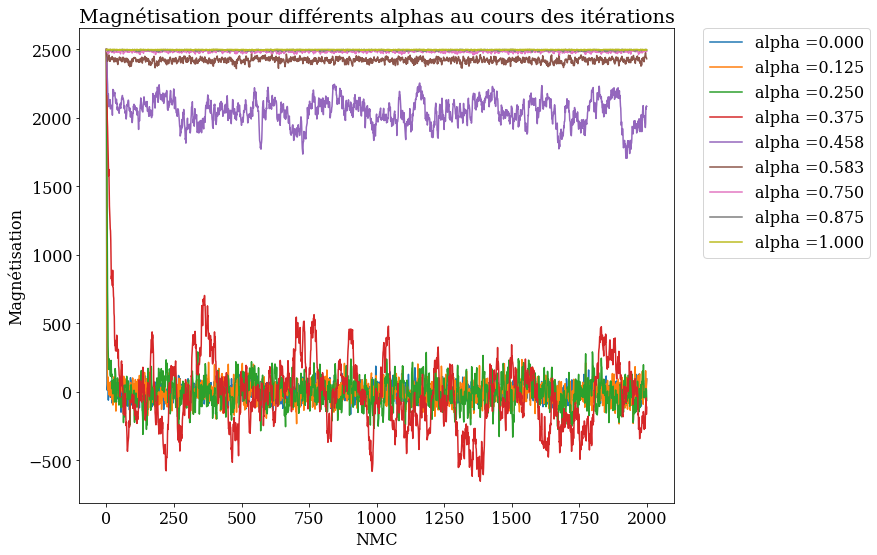

In [37]:
fig, ax=plt.subplots(figsize=(10,8))
NMC_array=np.linspace(0,100,100)
ind_pos=[0,3,6,9,11,14,18,21,24]
for i in (ind_pos):
    plt.plot(states_tot[i].sum(axis=(1,2)),label="alpha =%.3f" %index_alpha[i])
plt.legend()
handles, labels = ax.get_legend_handles_labels()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel(r'NMC')
plt.ylabel(r'Magnétisation')
plt.title(r'Magnétisation pour différents alphas au cours des itérations')

plt.tight_layout()

En grande approximation, on constate que pour les valeurs de alpha plus petites que 0.3, la transition se fait pratiquement instantanément, tandis que pour des valeurs plus grandes que 0.5, la transition semble se faire à des temps plus grands que ceux que nous avons considérés. Pour ces valeurs, on peut raisonnablement considérer que l'on peut commencer l'itération à NMC=50.

Pour les valeurs entre 0.3 et 0.5, les transitions ont lieu avant NMC=300. C'est donc un bon point de départ dans ce cas.

On définit maintenant la fonction qui va nous permettre de calculer l'énergie moyenne. 

Pour la ième valeur de alpha, on commence par initialiser l'énergie à 0. On recupère ensuite dans la variable *current_alpha* les états pertinents en prenant l'indice i dans notre grande matrice *states_tot*, correspondant à la valeur de alpha pour laquelle on souhaite faire l'analyse. 

Avec la remarque que nous avons faite sur base du graphique ce-dessus, ceci nous permet, selon le cas où l'on se trouve, de définir *NMC_start* comme le moment où l'on va commencer les calculs (donc l'itération à suivre). 

A partir de cet état de départ (ainsi que pour les 1700 suivants, afin de toujours faire le même nombre d'itérations quelque soit le cas de figure, et de ne pas dépasser le nombre d'états total à notre disposition), on va sommer les énergies de chaque petits carrés en position (n,j) dans notre état avec la fonction *energy_at_site*. L'énergie totale pour une valeur de alpha se calcule selon la formule:
$$
<E> = \frac{\sum_k E_k}{N_k}
$$
où l'on divise par le nombre d'états (NMC pour nous). Toutefois, il est également nécéssaire de diviser ce résultat par 2, puisque d'après la formule 
$$
E=-J\sum_{pairs(i,j)} s_i s_j,
$$
on va compter deux fois la contribution de chaque carrés sur ses voisins.

On va stocker finalement chacune des énergies moyennes pour les différentes valeurs de alpha dans une liste *energy_alpha*, qui est notre output.

In [21]:
def mean_energy(num,nx,ny, NMC, states_tot, index_alpha):
    """calcul l'énergie moyenne de la phase stabilisée
    Paramètres:
    ----------
    num: int
        iteration
    NMC: float
        nombre d'états
    nx,ny: int
           discretisation selon x et y respectivement
    states_tot: array
                états pour nos différents alpha
    index_alpha: array
                valeurs de alpha
    Returns:
    ---------
    energy_alpha     energie moyenne
    """
    
    energy_alpha=np.zeros(num)
    for i in range(num):
        energy_tot=0
        alpha=index_alpha[i]
        if 0.3<alpha<0.5:
            NMC_start=300
        else:
            NMC_start=50
        current_alpha=states_tot[i]
        for k in range(NMC_start, NMC_start+1700):
            current_state=current_alpha[k]
            for n in range(nx):
                for j in range(ny):
                    ener=energy_at_site(current_state,alpha,current_state[n,j],n,j, nx, ny)
                    energy_tot=energy_tot+ener
        scale=energy_tot/(2*NMC)
        energy_alpha[i]=scale
    return energy_alpha

On fait ensuite tourner ce code avec les valeurs souhaitées. 

In [22]:
energy_alpha=mean_energy(num,nx,ny,NMC, states_tot, index_alpha)

La démarche pour le calcul de la magnétisation est très similaire à celle pour l'énergie, si ce n'est le mode de calcul. Très simplement, comme la magnétisation d'un petit carré à la position (n,j) au sein un état est donné par sp[n,j] (en prenant les notations du MOOC), il suffit d'intérer sur les positions en x et en y et de sommer les magnétisations.

Comme précédemment, la magnétisation moyenne pour une valeur de alpha est donnée par: 
$$
<M> = \frac{\sum_k M_k}{N_k}
$$
où l'on divise simplement cette fois par le nombre d'états. Il n'y a pas à priori de double contribution.

Les magnétisations moyennes sont stockées dans la liste *mag_alpha*.

On fait ensuite tourner le code pour les valeurs voulues.

In [23]:
def mean_magnetisation(num, nx, ny, NMC, states_tot, index_alpha):
    """calcul la magnétisation moyenne de la phase stabilisée
    Paramètres:
    ----------
    num: int
        iteration
    NMC: float
        nombre d'états
    nx,ny: int
           discretisation selon x et y respectivement
    states_tot: array
                états pour nos différents alpha
    index_alpha: array
                valeurs de alpha
    Returns:
    ---------
    mag_alpha     magnétisation moyenne
    """
    
    mag_alpha=np.zeros(num)
    for i in range(num):
        mag_tot=0
        alpha=index_alpha[i]
        
        if 0.3<alpha<0.5:
            NMC_start=300
        else:
            NMC_start=50
        current_alpha=states_tot[i]
        for k in range(NMC_start, NMC_start+1200):
            current_state=current_alpha[k]
            for n in range(nx):
                for j in range(ny):
                    mag=current_state[n,j]
                    mag_tot=mag_tot+mag
        scale_mag=mag_tot/NMC
        mag_alpha[i]=scale_mag
    return mag_alpha

mag_alpha= mean_magnetisation(num,nx,ny,NMC, states_tot, index_alpha)

On peut maintenant réaliser le graphique attendu, en portant en graphique d'une part notre liste des différentes magnétisations en fonction de alpha, et d'une autre part la liste des énergies moyennes en fonction de alpha.

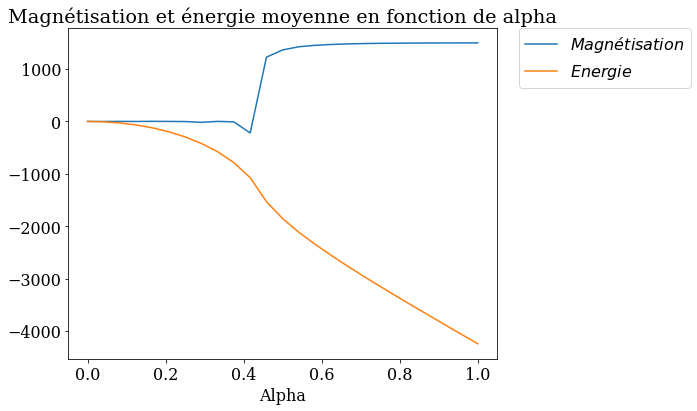

In [24]:
fig, ax=plt.subplots(figsize=(8,6))
plt.plot(index_alpha,mag_alpha, label=r'$Magnétisation$')
plt.plot(index_alpha,energy_alpha, label=r'$Energie$')
plt.legend()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel(r'Alpha')
plt.title(r'Magnétisation et énergie moyenne en fonction de alpha')
plt.tight_layout()

Graphiquement, on voit que notre transition (qui correspond visuellement par d'un palier) semble se produire autour de $\alpha=0.45$. Pour savoir si cette valeur est compatible avec la solution exacte de Onsager, on a regardé l'article Wikipédia suivant: https://en.wikipedia.org/wiki/Square-lattice_Ising_model 

On y voit que la valeur théorique de $\alpha=\frac{J}{k_BT}$ nous est donnée par la relation: 
$$\frac{k_BT_c}{J}=\frac{2}{ln(1+\sqrt{2})} \approx 2.26918531421$$
donc
$$\alpha=\frac{1}{2.26918531421}=0.440687$$
Notre graphique semble donc raisonnablement en accord avec la théorie.

3) Redo the analysis with a different set of boundary conditions for the lattice and a different initial lattice configuration. For example, you could assume that on the borders all the spins are pointing upwards on the borders while they are randomly oriented in the bulk.

Dans cette nouvelle analyse, on va partir d'un état initial où tous les spins sur le bord sont up (1), et ce bords est maintenu ainsi au cours du temps. Nous avons aussi enlever les conditions périodiques pour mettre des conditions non-périodiques. Ce dernier point est réalisé simplement en retirant les modulos dans la définition des conditions.

Il est donc nécessaire d'adapter les fonctions que nous avons précédemment utilisées.

D'abord, on modifie *energy_at_site*. Il faut distinguer 3 grands cas:

Si l'on se trouve sur un bord (mais pas sur un coin), on aura 3 voisins qui vont contribuer à l'énergie, et on veut un spin=1.

Si on est sur un coin, seul deux voisins vont contribuer à l'énergie, et de nouveau, on veut un spin up.

Autrement, le calcul de l'énergie se fait exactement comme dans le code original, avec un spin variable.

On implémente cela dans la fonction suivante, qui distingue en plus sur quel bords ou sur quel coin on se trouve.

In [25]:
def energy_at_site_bc(sp,alpha,sigma,sigma1,ix,iy,nx,ny):
    """ Computes the contribution to the energy for a given spin
    at location ix,iy for a lattice with boundary conditions
   
    Parameters:
    ----------
    sp: numpy array
        array of spins
    alpha  : real
        coupling constant J/(kb*T)
    sigma   : int
        spin at site ix,iy
    sigma1 : int
        spin on the borders
    ix   : int
        location in x
    iy   : int
        location in y
    nx   : int
        Discretization points in x
    ny   : int
        Discretization points in y
            
    
    Returns:
    -------
    energy: energy for the given configuration
    """
    
    #bordure composé de spin up uniquement
    if ix==0 :
        energy=-alpha*sigma1*(sp[(ix+1),iy]+sp[ix,(iy-1)]+sp[ix,(iy+1)])
    
    elif ix==nx-1 :
        energy=-alpha*sigma1*(sp[(ix-1),iy]+sp[ix,(iy-1)]+sp[ix,(iy+1)])
    
    elif iy==0 :
        energy=-alpha*sigma1*(sp[(ix-1),iy]+sp[(ix+1),iy]+sp[ix,(iy+1)])
    
    elif iy==ny-1 :
        energy=-alpha*sigma1*(sp[(ix-1),iy]+sp[(ix+1),iy]+sp[ix,(iy-1)])
    #coins    
    elif ix==0 and iy==0:
        energy=-alpha*sigma1*(sp[(ix+1),iy]+sp[ix,(iy+1)])
    
    elif ix==nx-1 and iy==0:
        energy=-alpha*sigma1*(sp[(ix-1),iy]+sp[ix,(iy+1)])
    
    elif iy==ny-1 and ix==0:
        energy=-alpha*sigma1*(sp[(ix+1),iy]+sp[ix,(iy-1)])
    
    elif iy==ny-1 and ix==nx-1:
        energy=-alpha*sigma1*(sp[(ix-1),iy]+sp[ix,(iy-1)])
    #carré intérieur
    else: 
        energy=-alpha*sigma*(sp[(ix-1),iy]+sp[(ix+1),iy]+sp[ix,(iy-1)]+sp[ix,(iy+1)])
        
    return energy

On modifie *metropolis_at_site* pour qu'il prenne en compte le nouveau mode de calcul de l'énergie précédemment défini. Ceci est simplement réalisé en remplaçant le nom de la fonction pour l'énergie, et en retournant le dipôle si on se trouve pas sur un bord ou sur un coin.

In [26]:
def metropolis_at_site_bc(sp,sigma1,alpha,ix,iy,nx,ny):
    """ Flips a dipole at site ix, iy when probability condition is met 
   
    Parameters:
    ----------
    sp: numpy array
        array of spins
    sigma1 : int
        spin on the borders
    ix   : int
        location in x
    alpha  : real
        coupling constant J/(kb*T)
    iy   : int
        location in y
    nx   : int
        Discretization points in x
    ny   : int
        Discretization points in y
    """
    sigma=sp[ix,iy]
    energy_before_flip = energy_at_site_bc(sp,alpha,sigma,sigma1,ix,iy,nx,ny)     
    sigma = -sigma
    energy_if_site_flipped = energy_at_site_bc(sp,alpha,sigma,sigma1,ix,iy,nx,ny)
    
    # Flip the site with Metropolis probability
    # Condition is always satisifed if dE < 0
    if (np.random.random_sample()<np.exp(-(energy_if_site_flipped \
                                               -energy_before_flip))):
         if ix!=0:
            if iy!=0:
                if ix!=nx-1:
                    if iy!=ny-1:
                        sp[ix,iy]=-sp[ix,iy]

On définit ensuite une fonction *initial_lattice*, qui nous rend un état initial composé de spin up au bord, et un intérieur aléatoire (d'où l'itération de 1 à nx-1 pour les positions en x et en y), en utilisant *metropolis_at_site_bc*. 

In [27]:
def initial_lattice(nx,ny, sigma1,alpha):
    r=np.ones((nx,ny))
    for j in range (1,(nx-1)*(ny-1)):
        ix=np.random.randint(1,nx-1)
        iy=np.random.randint(1,ny-1)
        metropolis_at_site_bc(r, sigma1, alpha,ix,iy,nx,ny)
    return r

On modifie finalement la fonction *ising_model_metropolis* en utilisant la nouvelle fonction *metropolis_at_site_bc* que l'on a précédemment défini. Seul l'interieur des états doit changer, donc on ne fait pas d'itérations sur le bord, d'où le fait que l'indice i aille de 1 à nx-1, et j de 1 à ny-1.

In [28]:
def  ising_model_metropolis_bc (sp2, sigma1, NMC, nx, ny, alpha):
    """ Creates a sequence of states for the Ising model using
    the Metropolis algorithm
   
    Parameters:
    ----------
    sp2   : initial lattice state
    sigma1 : int
        spin on the borders
    nx   : int
        Discretization points in x
    ny   : int
        Discretization points in y
    NMC  : int
        Number of states to create
    alpha  : real
        coupling constant J/(kb*T)
    Returns:
    -------
    states: sequence of states
    """
    states1 = np.empty([NMC+1,nx,ny])
    states1[0] = sp2.copy()
    
    for i in range(1,NMC+1):
        for j in range(1,(nx-1)*(ny-1)):
            ix=np.random.randint(1,nx-1)
            iy=np.random.randint(1,ny-1)
            metropolis_at_site_bc(sp2, sigma1, alpha,ix,iy,nx,ny)
        states1[i]=sp2.copy()
    return states1

Nous allons utiliser les mêmes valeurs de paramètres que pour le challenge précédant. On construit également notre liste de valeurs de alpha comme précédemment.

In [29]:
sigma1=1
nx2=50
ny2=50
NMC2=2000
num2=25
index_alpha2=np.linspace(0,1,num2)

De nouveau, on définit une fonction *states2* qui nous rend une liste de NMC2 états pour chacune de ces valeurs. On voit qu'il y a une nouvelle varible *sp2*, qui est l'état initial généré pour chaque valeur de alpha, sur lequel on va appliquer la fonction *ising_model_metropolis_bc*. Cet état initital sera donnée par la fonction *initial_lattice*.

La justification sur l'utilisation de la commande *append* est la même que pour la fonction analogue du challenge précédant.

In [33]:
def states2(num2, sigma1, NMC2,nx2,ny2, index_alpha2):
    states_tot2=[]
    for i in range(num2):
        alpha=index_alpha2[i]
        sp2=initial_lattice(nx2,ny2,sigma1,alpha)
        states_alpha2=ising_model_metropolis_bc(sp2, sigma1, NMC2, nx2, ny2, alpha)
        states_tot2.append(states_alpha2)
    return states_tot2

On fait, comme d'habitude, tourner nos différents codes pour les valeurs que l'on souhaite.

In [34]:
states_tot2=states2(num2, sigma1, NMC2,nx2,ny2, index_alpha2)

Le calcul de l'énergie et de la magnétisation se fait exactement comme dans le challenge précédant, en utilisant toutefois les nouvelles fonctions. Nous devons toutefois itérer sur les positions en x,y jusque respectivement nx-1 et ny-1, sans quoi nous avions une erreur de taille, que nous ne nous expliquons pas, et que l'on ne savait pas résoudre autrement pour l'énergie. Par cohérence, on a effectué la même itération pour la magnétisation, bien que le problème ne se posait pas.

On va vérifier si les points de départ que nous avons choisis dans le point précédent tiennent toujours:

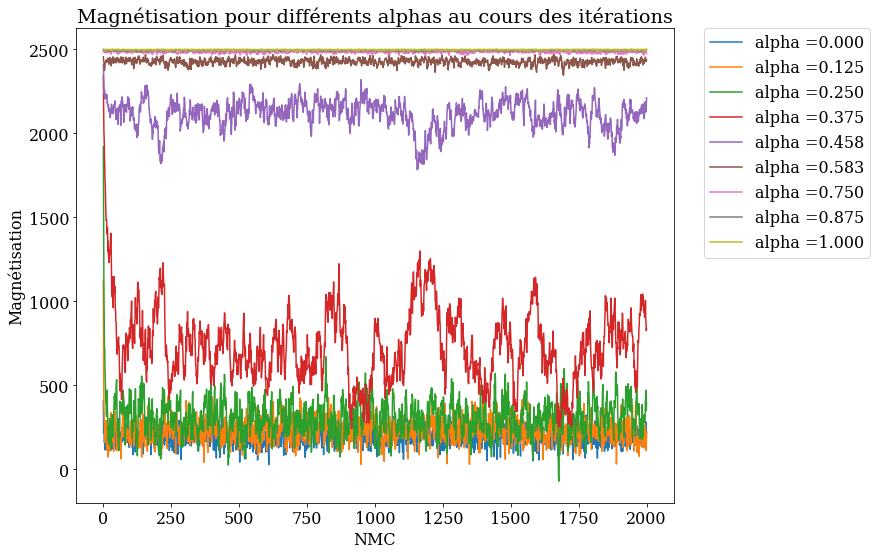

In [36]:
fig, ax=plt.subplots(figsize=(10,8))
NMC_array=np.linspace(0,100,100)
ind_pos2=[0,3,6,9,11,14,18,21,24]
for i in (ind_pos2):
    plt.plot(states_tot2[i].sum(axis=(1,2)),label="alpha =%.3f" %index_alpha2[i])
plt.legend()
handles, labels = ax.get_legend_handles_labels()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel(r'NMC')
plt.ylabel(r'Magnétisation')
plt.title(r'Magnétisation pour différents alphas au cours des itérations')

plt.tight_layout()

On pose donc les même points de départ pour l'itération que précédemment, comme il n'y a à priori pas eu à priori de gros changements.

In [43]:
def mean_energy2 (num2,nx2,ny2, NMC2, states_tot2, index_alpha2):
    energy_alpha2=np.zeros(num2)
    for i in range(num2):
        energy_tot2=0
        alpha=index_alpha2[i]
        if 0.3<alpha<0.5:
            NMC_start=300   
        else:
            NMC_start=50
        current_alpha=states_tot2[i]
        for k in range(NMC_start, NMC_start+1700):   
            current_state=current_alpha[k]
            for n in range(nx2-1):
                for j in range(ny2-1):
                    ener=energy_at_site_bc(current_state,alpha,current_state[n,j],sigma1,n,j,nx2,ny2)
                    energy_tot2=energy_tot2+ener
        scale2=energy_tot2/(2*NMC)
        energy_alpha2[i]= scale2
    return energy_alpha2

In [44]:
def mean_magnetisation2(num2, nx2, ny2, NMC2, states_tot2, index_alpha2):
    mag_alpha2=np.zeros(num2)
    for i in range(num2):
        mag_tot=0
        alpha=index_alpha2[i]
        if 0.3<alpha<0.50:
            NMC_start=300  
        else:
            NMC_start=50
        current_alpha=states_tot2[i]
        for k in range(NMC_start, NMC_start+1700):     
            current_state=current_alpha[k]
            for n in range(nx2-1):
                for j in range(ny2-1):
                    mag=current_state[n,j]
                    mag_tot=mag_tot+mag
        scale_mag2=mag_tot/(NMC)
        mag_alpha2[i]= scale_mag2
    return mag_alpha2

In [45]:
energy_alpha2=mean_energy2(num2,nx2,ny2, NMC2, states_tot2, index_alpha2)
mag_alpha2=mean_magnetisation2(num2, nx2, ny2, NMC2, states_tot2, index_alpha2)

On peut finalement obtenir un graphique que l'on pourra comparer avec ce que l'on obtenait si on laissait des conditions périodiques et qu'on n'imposait pas de conditions sur les bords.

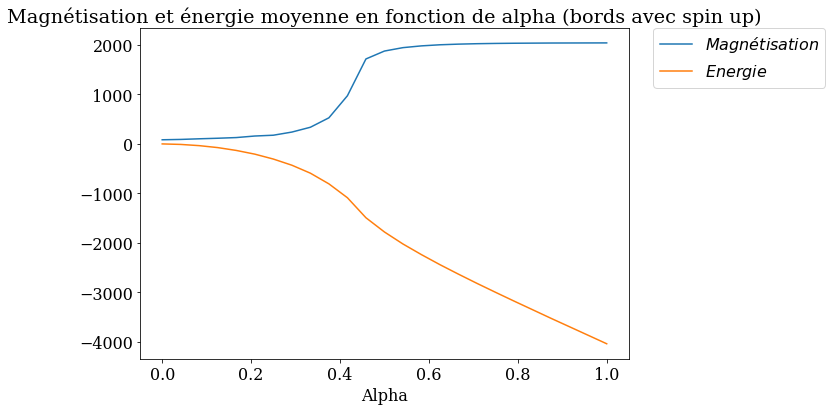

In [51]:
fig, ax=plt.subplots(figsize=(10,6))
plt.plot(index_alpha2,mag_alpha2, label=r'$Magnétisation$')
plt.plot(index_alpha2,energy_alpha2, label=r'$Energie$')
plt.legend()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel(r'Alpha')
plt.title(r'Magnétisation et énergie moyenne en fonction de alpha (bords avec spin up)')
plt.tight_layout()

On constate quelques différences avec le premier graphique, où l'on avait des conditions aux bords périodiques. On peut le réafficher pour faciliter la comparaison. 

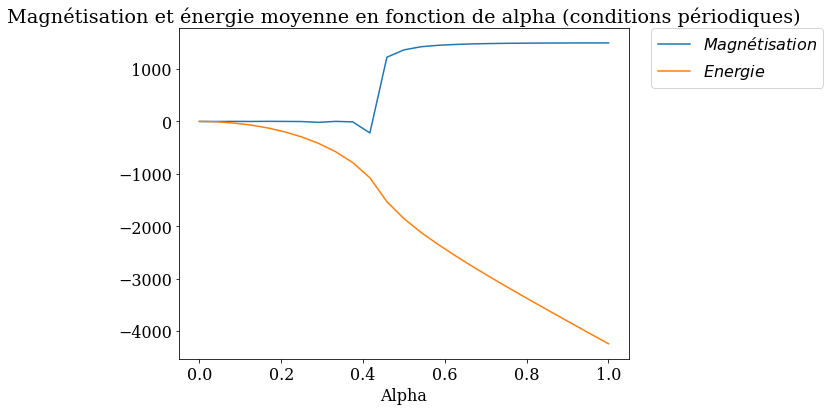

In [49]:
fig, ax=plt.subplots(figsize=(10,6))
plt.plot(index_alpha,mag_alpha, label=r'$Magnétisation$')
plt.plot(index_alpha,energy_alpha, label=r'$Energie$')
plt.legend()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel(r'Alpha')
plt.title(r'Magnétisation et énergie moyenne en fonction de alpha (conditions périodiques)')
plt.tight_layout()

On voit tout d'abord que la magnétisation moyenne est plus haute si on maintient le bord avec des spins up, et qu'elle n'est pas initialement nulle. Ceci semble cohérent avec notre intuition, puisqu'à priori, on maintient un certain déséquilibre entre le nombre de spins down et le nombre de spins up. 

On voit aussi qu'il n'y a plus, contrairement au cas avec des conditions périodiques, la soudaine baisse de magnétisation, où elle est momentanément négative, avant la transition. La transition est également moins nette graphiquement de ce fait.

On remarque toutefois que la valeur critique $\alpha_c$ ne semble pas avoir changée, de même pour les valeurs des énergies moyennes.